In [7]:
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from croptrain import add_croptrainer_config, add_ubteacher_config
from detectron2.data import DatasetCatalog, MetadataCatalog
import os
from croptrain.data.datasets.visdrone import register_visdrone
from croptrain.engine.trainer import UBTeacherTrainer, BaselineTrainer
from detectron2.utils.visualizer import Visualizer
from PIL import Image
import numpy as np
from detectron2.evaluation import DatasetEvaluator, print_csv_format
import torch
import datetime
import time
import copy
import cv2
from contextlib import ExitStack, contextmanager
from torchvision.transforms import Resize
from detectron2.structures.instances import Instances
from detectron2.structures.boxes import Boxes, pairwise_iou, BoxMode
from croptrain.data.detection_utils import read_image
import matplotlib.pyplot as plt
import logging
from detectron2.data.build import get_detection_dataset_dicts
from detectron2.utils.logger import log_every_n_seconds
from detectron2.modeling.roi_heads.fast_rcnn import fast_rcnn_inference
from croptrain.data.datasets.visdrone import compute_crops
logging.basicConfig(level = logging.INFO)

In [8]:
@contextmanager
def inference_context(model):
    """
    A context where the model is temporarily changed to eval mode,
    and restored to previous mode afterwards.

    Args:
        model: a torch Module
    """
    training_mode = model.training
    model.eval()
    yield
    model.train(training_mode)


def get_dict_from_crops(crops, input_dict, CROPSIZE):
    if len(crops)==0:
        return []
    if isinstance(crops, Instances):
        crops = crops.pred_boxes.tensor.cpu().numpy().astype(np.int32)
    transform = Resize(CROPSIZE)
    crop_dicts, crop_scales = [], []
    for i in range(len(crops)):
        x1, y1, x2, y2 = crops[i, 0], crops[i, 1], crops[i, 2], crops[i, 3]
        crop_size_min = min(x2-x1, y2-y1)
        if crop_size_min<=0:
            continue
        crop_dict = copy.deepcopy(input_dict)
        crop_dict['full_image'] = False
        crop_dict['crop_area'] = np.array([x1, y1, x2, y2])
        crop_region = read_image(crop_dict)
        crop_region = torch.as_tensor(np.ascontiguousarray(crop_region.transpose(2, 0, 1)))
        crop_region = transform(crop_region)
        crop_dict["image"] = crop_region
        crop_dict["height"] = (y2-y1)
        crop_dict["width"] = (x2-x1)
        crop_dicts.append(crop_dict)
        crop_scales.append(float(CROPSIZE)/crop_size_min)

    return crop_dicts


In [3]:
def plot_detections(predictions, cluster_boxes, data_dict, metadata):
    if data_dict["full_image"]:
        img = np.array(Image.open(data_dict["file_name"]))
        predictions = predictions[predictions.scores>0.2]
    else:
        img = data_dict["image"]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        predictions = predictions[predictions.scores>0.5]
    visualizer = Visualizer(img, metadata=metadata)
    vis = visualizer.draw_instance_predictions(predictions)
    if cluster_boxes is not None:
        if len(cluster_boxes)==0:
            print("No clusters")
            return
        cluster_colors = len(cluster_boxes)*['g']
        if isinstance(cluster_boxes, Instances):
            cluster_boxes = cluster_boxes.pred_boxes.tensor.cpu()
        vis = visualizer.overlay_instances(boxes=cluster_boxes, assigned_colors=cluster_colors)
    if data_dict["full_image"]:
        plt.figure(figsize=(10,8))
    else:
        plt.figure(figsize=(5,4))
    plt.imshow(vis.get_image()[..., ::-1][..., ::-1])
    #plt.show()

def plot_image(data_dict, cfg, metadata):
    img = np.array(Image.open(data_dict["file_name"]))
    visualizer = Visualizer(img, metadata=metadata)
    vis = visualizer.draw_dataset_dict(data_dict)
    save_path = os.path.join(cfg.OUTPUT_DIR, "input", data_dict["file_name"].split('/')[-1])
    vis.save(save_path)

In [12]:
def get_box_predictions(model, features, proposals):
    features = [features[f] for f in model.roi_heads.box_in_features]
    box_features = model.roi_heads.box_pooler(features, [x.proposal_boxes for x in proposals])
    box_features = model.roi_heads.box_head(box_features)
    predictions = model.roi_heads.box_predictor(box_features)
    del box_features
    boxes = model.roi_heads.box_predictor.predict_boxes(predictions, proposals) # Nx(CxB)
    scores = model.roi_heads.box_predictor.predict_probs(predictions, proposals)
    return list(boxes), list(scores)

def project_boxes_to_image(data_dict, crop_sizes, boxes, scores, idx, metadata):
    num_bbox_reg_classes = boxes.shape[1] // 4
    output_height, output_width = data_dict.get("height"), data_dict.get("width")
    new_size = (output_height, output_width)
    scale_x, scale_y = (
        output_width / crop_sizes[1],
        output_height / crop_sizes[0],
    )
    boxes = Boxes(boxes.reshape(-1, 4))
    boxes.scale(scale_x, scale_y)
    boxes.clip(new_size)
    boxes = boxes.tensor

    #shift to the proper position of the crop in the image
    if not data_dict["full_image"]:
        if idx%100==0:
            scores = scores[:, :-1]
            filter_mask = scores > 0.1
            filter_inds = filter_mask.nonzero()
            temp = copy.deepcopy(data_dict)
            result = Instances(new_size)
            result.pred_boxes = Boxes(boxes[filter_mask.flatten()])
            result.pred_classes = filter_inds[:, 1]
            result.scores = scores[filter_mask]
            cluster_class = len(metadata.thing_classes)
            result = result[result.pred_classes!=cluster_class]
            image = read_image(data_dict)
            temp["image"] = image
            #plot_detections(result.to("cpu"), None, temp, metadata)
        x1, y1 = data_dict["crop_area"][0], data_dict["crop_area"][1]
        ref_point = torch.tensor([x1, y1, x1, y1]).to(boxes.device)
        boxes = boxes + ref_point
    boxes = boxes.view(-1, num_bbox_reg_classes*4) # R x C x 4
    return boxes

def infer_on_image_and_crops(input_dicts, cluster_dicts, model, cfg, idx):
    metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])
    images_original = model.preprocess_image(input_dicts)
    features_original = model.backbone(images_original.tensor)
    proposals_original, _ = model.proposal_generator(images_original, features_original, None)
    image_shapes = [(item.get("height"), item.get("width")) for item in input_dicts]
    #get detections from full image and project it to original image size
    boxes, scores = get_box_predictions(model, features_original, proposals_original)
    boxes[0] = project_boxes_to_image(input_dicts[0], images_original.image_sizes[0], boxes[0], scores[0], idx, metadata)
    del features_original
    
    
    if cluster_dicts:
        for i, cluster_dict in enumerate(cluster_dicts):
            images_crop = model.preprocess_image([cluster_dict])
            features_crop = model.backbone(images_crop.tensor)
            proposals_crop, _ = model.proposal_generator(images_crop, features_crop, None)
            #get detections from crop and project it to wrt to original image size
            boxes_crop, scores_crop = get_box_predictions(model, features_crop, proposals_crop)
            boxes_crop = project_boxes_to_image(cluster_dict, images_crop.image_sizes[0], boxes_crop[0], scores_crop[0], idx, metadata)
            boxes[0] = torch.cat([boxes[0], boxes_crop], dim=0)
            scores[0] = torch.cat([scores[0], scores_crop[0]], dim=0)
            
    pred_instances, _ = fast_rcnn_inference(boxes, scores, image_shapes, cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST, \
        cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST, 800)
    return pred_instances[0]


def inference_on_dataset(model, data_loader, evaluator, cfg):
    from detectron2.utils.comm import get_world_size
    #dataset_dicts = get_detection_dataset_dicts(cfg.DATASETS.TEST, filter_empty=cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS)

    num_devices = get_world_size()
    logger = logging.getLogger(__name__)
    logger.info("Start inference on {} batches".format(len(data_loader)))

    total = len(data_loader)  # inference data loader must have a fixed length
    if evaluator is None:
        # create a no-op evaluator
        evaluator = DatasetEvaluators([])
    evaluator.reset()
    save_dir = os.path.join(cfg.OUTPUT_DIR, "detections")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    #last_class = evaluator._metadata.get("thing_classes")[-1]
    #if last_class=="cluster":
    #    all_classes = evaluator._metadata.get("thing_classes")
    #    evaluator._metadata.__dict__['thing_classes'] =  all_classes[:-1]
    #    evaluator._metadata.__dict__['thing_dataset_id_to_contiguous_id'].pop(cfg.MODEL.ROI_HEADS.NUM_CLASSES)

    num_warmup = min(5, total - 1)
    start_time = time.perf_counter()
    total_data_time = 0
    total_compute_time = 0
    total_eval_time = 0
    cluster_class = cfg.MODEL.ROI_HEADS.NUM_CLASSES - 1
    with ExitStack() as stack:
        if isinstance(model, torch.nn.Module):
            stack.enter_context(inference_context(model))
        stack.enter_context(torch.no_grad())

        start_data_time = time.perf_counter()
        for idx, inputs in enumerate(data_loader):
            total_data_time += time.perf_counter() - start_data_time
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_data_time = 0
                total_compute_time = 0
                total_eval_time = 0

            start_compute_time = time.perf_counter()
            outputs = model.inference(batched_inputs=inputs)
            cluster_class_indices = (outputs[0]["instances"].pred_classes==cluster_class)
            cluster_boxes = outputs[0]["instances"][cluster_class_indices]
            cluster_boxes = cluster_boxes[cluster_boxes.scores>0.6]
            outputs[0]["instances"] = outputs[0]["instances"][~cluster_class_indices]
            all_instances = [outputs[0]["instances"]]

            #_, clus_dicts = compute_crops(dataset_dicts[idx], cfg)
            #cluster_boxes = np.array([item['crop_area'] for item in clus_dicts]).reshape(-1, 4)
            #"""
            if len(cluster_boxes)!=0:
                #cluster_boxes = merge_cluster_boxes(cluster_boxes, cfg)
                cluster_dicts = get_dict_from_crops(cluster_boxes, inputs[0], cfg.CROPTRAIN.CROPSIZE)
                pred_instances = infer_on_image_and_crops(inputs, cluster_dicts, model, cfg, idx)
            else:
                pred_instances = infer_on_image_and_crops(inputs, None, model, cfg, idx)
            #"""    
            pred_instances = pred_instances[pred_instances.pred_classes!=cluster_class]
            #all_outputs = [{"instances": Instances.cat(all_instances)}]
            all_outputs = [{"instances": pred_instances}]
            
            if idx%100==0:
                plot_detections(all_instances[0].to("cpu"), cluster_boxes, inputs[0], evaluator._metadata)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time

            start_eval_time = time.perf_counter()
            evaluator.process(inputs, all_outputs)
            total_eval_time += time.perf_counter() - start_eval_time

            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            data_seconds_per_iter = total_data_time / iters_after_start
            compute_seconds_per_iter = total_compute_time / iters_after_start
            eval_seconds_per_iter = total_eval_time / iters_after_start
            total_seconds_per_iter = (time.perf_counter() - start_time) / iters_after_start
            if idx >= num_warmup * 2 or compute_seconds_per_iter > 5:
                eta = datetime.timedelta(seconds=int(total_seconds_per_iter * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    (
                        f"Inference done {idx + 1}/{total}. "
                        f"Dataloading: {data_seconds_per_iter:.4f} s/iter. "
                        f"Inference: {compute_seconds_per_iter:.4f} s/iter. "
                        f"Eval: {eval_seconds_per_iter:.4f} s/iter. "
                        f"Total: {total_seconds_per_iter:.4f} s/iter. "
                        f"ETA={eta}"
                    ),
                    n=5,
                )
            start_data_time = time.perf_counter()

    # Measure the time only for this worker (before the synchronization barrier)
    total_time = time.perf_counter() - start_time
    total_time_str = str(datetime.timedelta(seconds=total_time))
    # NOTE this format is parsed by grep
    logger.info(
        "Total inference time: {} ({:.6f} s / iter per device, on {} devices)".format(
            total_time_str, total_time / (total - num_warmup), num_devices
        )
    )
    total_compute_time_str = str(datetime.timedelta(seconds=int(total_compute_time)))
    logger.info(
        "Total inference pure compute time: {} ({:.6f} s / iter per device, on {} devices)".format(
            total_compute_time_str, total_compute_time / (total - num_warmup), num_devices
        )
    )

    results = evaluator.evaluate()
    # An evaluator may return None when not in main process.
    # Replace it by an empty dict instead to make it easier for downstream code to handle
    if results is None:
        results = {}
    return results

INFO:detectron2.engine.defaults:Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2

No clusters


INFO:detectron2:Inference done 444/548. Dataloading: 0.0013 s/iter. Inference: 0.1031 s/iter. Eval: 0.0007 s/iter. Total: 0.1052 s/iter. ETA=0:00:10
INFO:detectron2:Inference done 493/548. Dataloading: 0.0013 s/iter. Inference: 0.1028 s/iter. Eval: 0.0007 s/iter. Total: 0.1050 s/iter. ETA=0:00:05
INFO:detectron2:Inference done 535/548. Dataloading: 0.0013 s/iter. Inference: 0.1041 s/iter. Eval: 0.0007 s/iter. Total: 0.1062 s/iter. ETA=0:00:01
INFO:__main__:Total inference time: 0:00:57.521804 (0.105933 s / iter per device, on 1 devices)
INFO:__main__:Total inference pure compute time: 0:00:56 (0.103804 s / iter per device, on 1 devices)
INFO:detectron2.evaluation.coco_evaluation:Preparing results for COCO format ...
INFO:detectron2.evaluation.coco_evaluation:Saving results to ./output/inference/coco_instances_results.json
INFO:detectron2.evaluation.coco_evaluation:Evaluating predictions with unofficial COCO API...


Loading and preparing results...


INFO:detectron2.evaluation.fast_eval_api:Evaluate annotation type *bbox*


DONE (t=0.52s)
creating index...
index created!


INFO:detectron2.evaluation.fast_eval_api:COCOeval_opt.evaluate() finished in 1.17 seconds.
INFO:detectron2.evaluation.fast_eval_api:Accumulating evaluation results...
INFO:detectron2.evaluation.fast_eval_api:COCOeval_opt.accumulate() finished in 0.21 seconds.
INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |  APs   |  APm   |  APl   |
|:------:|:------:|:------:|:------:|:------:|:------:|
| 27.779 | 51.410 | 26.845 | 21.106 | 37.139 | 36.742 |
INFO:detectron2.evaluation.coco_evaluation:Per-category bbox AP: 
| category   | AP     | category        | AP     | category   | AP     |
|:-----------|:-------|:----------------|:-------|:-----------|:-------|
| pedestrian | 27.894 | people          | 19.913 | bicycle    | 12.780 |
| car        | 55.403 | van             | 35.888 | truck      | 25.022 |
| tricycle   | 20.237 | awning-tricycle | 12.384 | bus        | 43.132 |
| motor      | 25.141 |                 |        |            |     

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.371
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.465
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.552


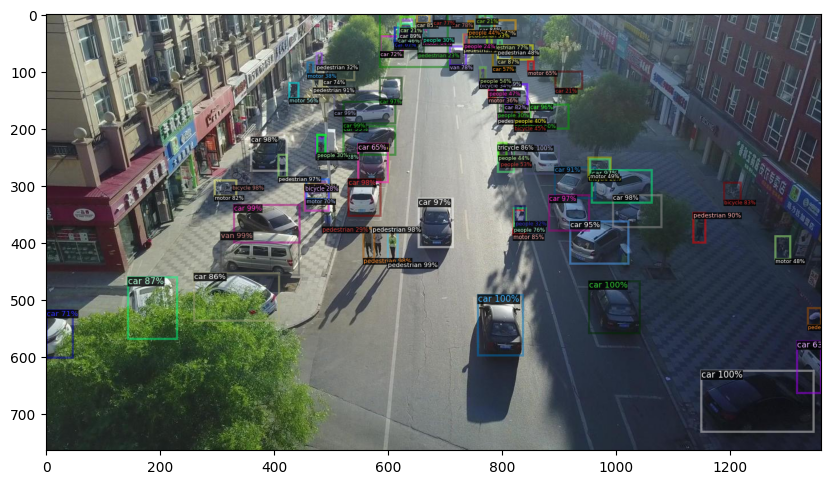

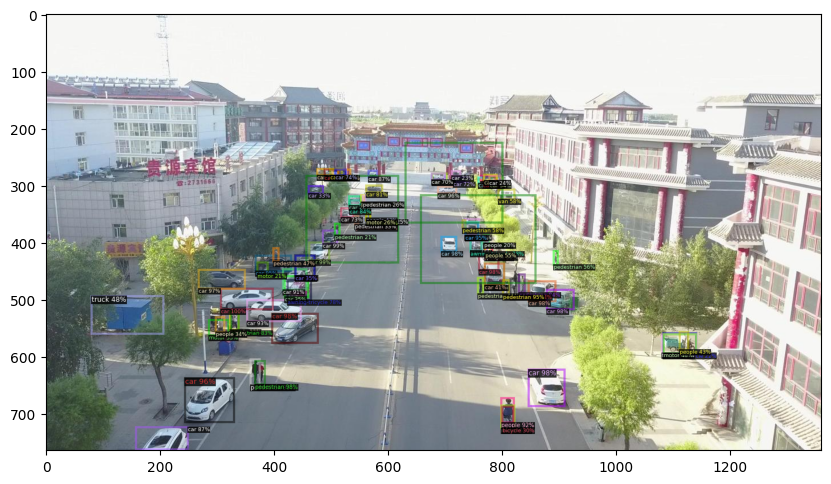

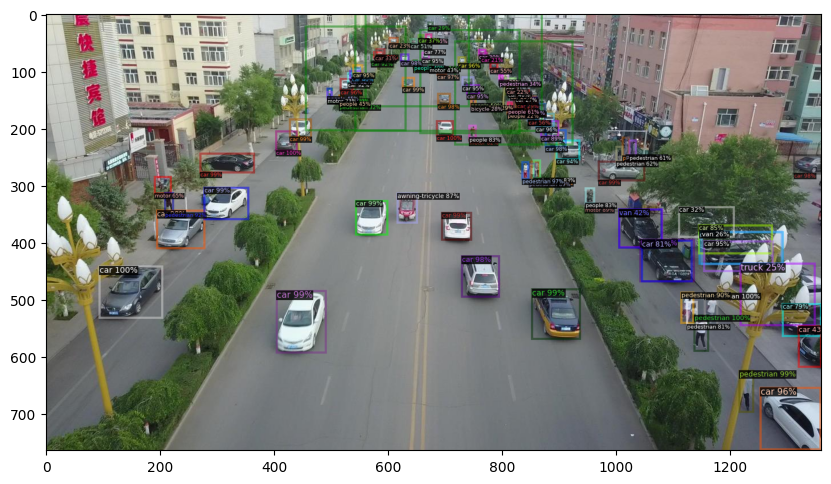

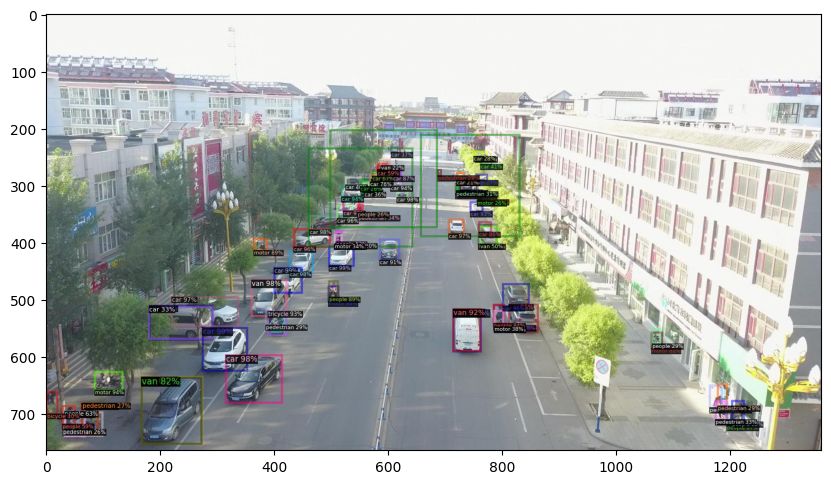

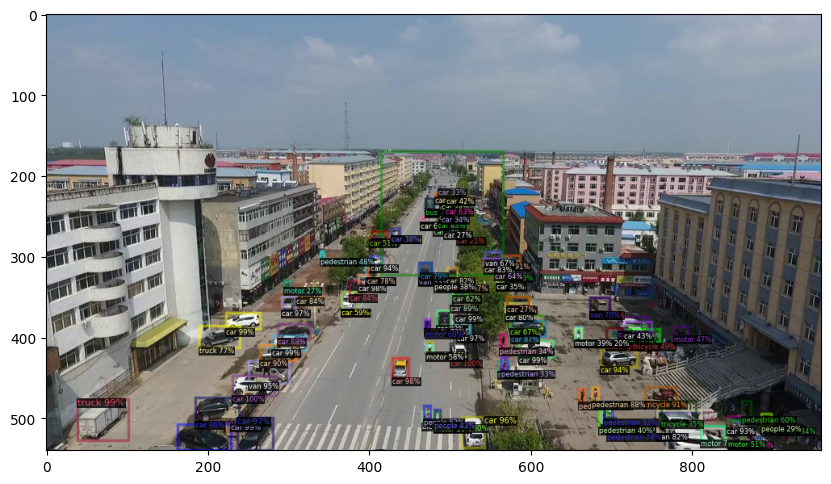

In [13]:
cfg = get_cfg()
add_croptrainer_config(cfg)
add_ubteacher_config(cfg)
cfg.merge_from_file(os.path.join(os.getcwd(), 'configs', 'RCNN-FPN-CROP.yaml'))
cfg.MODEL.ROI_HEADS.NUM_CLASSES += 1
cfg.MODEL.RETINANET.NUM_CLASSES += 1
data_dir = os.path.join(os.environ['SLURM_TMPDIR'], "VisDrone")
dataset_name = cfg.DATASETS.TEST[0]
#register_visdrone(cfg.DATASETS.TEST[0], data_dir, cfg, False)
if cfg.SEMISUPNET.USE_SEMISUP:
    Trainer = UBTeacherTrainer
else:
    Trainer = BaselineTrainer

model = Trainer.build_model(cfg)
model_weights = "/home/akhil135/scratch/detectron2/FPN_CROP/model_0054999.pth"
DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(model_weights, resume=False)
data_loader = Trainer.build_test_loader(cfg, dataset_name)
evaluator = Trainer.build_evaluator(cfg, dataset_name)
#print(evaluator)
results = inference_on_dataset(model, data_loader, evaluator, cfg)
print_csv_format(results)